In [1]:
import numpy as np
import math
import time
#import pymeshlab
#import potpourri3d as pp3d
import polyscope as ps
from barmesh.tribarmes import trianglebarmesh
from barmesh.basicgeo import P3

In [2]:
#ms = pymeshlab.MeshSet()
#fname = 'geometry/simple_geom.stl'
#fname = 'geometry/spot_triangulated.stl'
#fname = 'geometry/duct.stl'
fname = 'geometry/PPR-fine.stl'
#fname = 'geometry/twoWonkyTriangles.stl'
#ms.load_new_mesh(fname)
#V, F = pp3d.read_mesh(fname)
tbm = trianglebarmesh.TriangleBarMesh(fname)
#n = ms.current_mesh().face_normal_matrix()
V = tbm.GetVertices()
F = tbm.GetFaces()
n = tbm.GetNormals()

In [3]:
def pointOnEdge(i, l):
    pt1 = tbm.bars[i].GetNodeFore(True).p
    pt2 = tbm.bars[i].GetNodeFore(False).p
    vec12 = (pt2[0]-pt1[0],pt2[1]-pt1[1],pt2[2]-pt1[2])
    ptl = P3(pt1[0]+l*vec12[0],pt1[1]+l*vec12[1],pt1[2]+l*vec12[2])
    return ptl

def P3list2array(P3list):
    pts =[]
    for p in P3list:
        pts.append((p.x,p.y,p.z))
    return np.array(pts)


def find_rot(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """

    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def find_intersection(p1,vec1,p2,vec2, tol= 1e-6):
    flip = vec2.y ==0
    if flip:
        p1,vec1,p2,vec2 = p2,vec2,p1,vec1
    a = (p2.x+(vec2.x*p1.y-vec2.x*p2.y)/vec2.y-p1.x) / (vec1.x - vec2.x*vec1.y/vec2.y)
    b = (p1.y+ a*vec1.y-p2.y)/vec2.y
    p_int1 = P3(p1.x+ a*vec1.x,p1.y+ a*vec1.y,p1.z+ a*vec1.z)
    #print('tol ',abs((p1.z+ a*vec1.z)-(p2.z+ b*vec2.z)))
    assert abs((p1.z+ a*vec1.z)-(p2.z+ b*vec2.z)) < tol, "Lines do not intersect in 3D space"    
    if flip:
        a = b
    return p_int1,a

#function to rotate a P3 vector about an axis (of any length) and an angle in degrees
def rotAxisAngle(v,ax,a):
    ax = P3.ZNorm(ax)
    c = np.cos(np.radians(a))
    s = np.sin(np.radians(a))
    C = 1 - np.cos(np.radians(a))
    Q= np.array(((ax.x*ax.x*C+c,      ax.x*ax.y*C-ax.z*s, ax.x*ax.z*C+ax.y*s),
                 (ax.y*ax.x*C+ax.z*s, ax.y*ax.y*C+c,      ax.y*ax.z*C-ax.x*s),
                 (ax.z*ax.x*C-ax.y*s, ax.z*ax.y*C+ax.x*s, ax.z*ax.z*C+c)))
    v = np.dot(Q,np.array((v.x,v.y,v.z)))
    return P3(v[0],v[1],v[2])
    


In [4]:
# axis is a b
# incoming at d = Along(lam, a, b)
# incoming from c to d 
# incoming (d - c).(b - a) = |d-c||b-a|cos(theta) = |d-c|I
# I = |b-a|cos(theta) = (d - c).(b - a)/|d-c|

# triangle on right hand side is to e
# outgoing to x where x = Along(q, a, e) or x = Along(q, b, e)
# Solve (x - d).(b - a) = |x-d||b-a|cos(theta) = |x-d|I

# Set d = 0, v = b - a
# x.v = |x|I  where x = a + (e - a)*q = a + f*q
# x.x I^2 = (x.v)^2

# x.x I^2 = (a + f*q)^2 I^2 = q^2 f^2 I^2 + 2q a.f I^2 + a^2 I^2
#   =
# (x.v)^2 = (a.v + f.v*q)^2 = q^2 (f.v)^2 + 2q (a.v)(f.v) + (a.v)^2
# q^2 ((f.v)^2 - f^2 I^2) + 2q ((a.v)(f.v) - a.f I^2) + (a.v)^2 - a^2 I^2

def Square(X):
    return X*X
def TOL_ZERO(X):
    if not (abs(X) < 0.0001):
        print("TOL_ZERO fail", X)

def GeoCrossAxisE(a, Vae, Vab, Isq, Isgn):
    # Solve: Isq*x.Lensq() - Square(P3.Dot(x, Vab)) = 0   for x = a + Vae*q
    # 0 = Isq*(a^2 + 2q a.Vae + q^2 Vae^2) - (a.Vab + Vae.Vab q)^2
    #   = Isq*(a^2 + 2q adf + q^2 Vae^2) - (adv + fdv q)^2

    fdv = P3.Dot(Vae, Vab)
    adv = P3.Dot(a, Vab)
    adf = P3.Dot(a, Vae)
    qA = Square(fdv) - Vae.Lensq()*Isq
    qB2 = adv*fdv - adf*Isq
    qC = Square(adv) - a.Lensq()*Isq
    if abs(qA) <= abs(qB2)*1e-7:
        if qB2 == 0:
            return -1.0
        q = -qC/(2*qB2)
    else:
        qdq = Square(qB2) - qA*qC
        if qdq < 0.0:
            #print("qdq", qdq)
            return -1.0
        qs = math.sqrt(qdq) / qA
        qm = -qB2 / qA
        q = qm + qs*Isgn
    # q = qs +- qm,  x = a + Vae*q,  Dot(x, Vab) same sign as Dot(Vcd, Vab)
    if abs(q) < 100:
        TOL_ZERO(qA*Square(q) + qB2*2*q + qC)
    return q

#
# This is the basic function that crosses from one triangle to the next
#
def GeoCrossAxis(Ga, Gb, Gc, lam, Ge):
    Vab = Gb - Ga
    Gd = Ga + Vab*lam
    Vcd = Gd - Gc
    if Vcd.Len() == 0:
        bEnd = True
        bAEcrossing = False
        q = 0
        Gx = Gc
    else:
        bEnd = False
        cdDab = P3.Dot(Vcd, Vab)
        Isq = Square(cdDab) / Vcd.Lensq()
        Isgn = -1 if cdDab < 0 else 1
        qVae = GeoCrossAxisE(Ga - Gd, Ge - Ga, Vab, Isq, Isgn)
        qVbe = GeoCrossAxisE(Gb - Gd, Ge - Gb, -Vab, Isq, -Isgn)
        bAEcrossing = (abs(qVae - 0.5) < abs(qVbe - 0.5))
        q = qVae if bAEcrossing else qVbe
        Gx = (Ga + (Ge - Ga)*q) if bAEcrossing else (Gb + (Ge - Gb)*q)
        Dx = Gx - Gd
        TOL_ZERO(Isq - Square(P3.Dot(Dx, Vab)/Dx.Len()))
        TOL_ZERO(P3.Dot(Vcd, Vab)/Vcd.Len() - P3.Dot(Dx, Vab)/Dx.Len())
    return bAEcrossing, q, Gx, bEnd

In [5]:
# This is the iterative function that goes from bar to bar through the mesh
# c=from point, bar the crossing edge, lam the point on the bar, and bGoRight is the crossing direction
#
def GeoCrossBar(c, bar, lam, bGoRight, bPrintvals=False):
    bEnd = False
    Na, Nb = bar.nodeback, bar.nodefore
    if bGoRight:
        if bar.barforeright == None:
            bEnd = True
            Ne = trianglebarmesh.TriangleNode(P3(bar.nodefore.p.x+0.01,bar.nodefore.p.y+0.01,bar.nodefore.p.z+0.01),-1)
        else:
            Ne = bar.barforeright.GetNodeFore(bar.barforeright.nodeback == bar.nodefore)
    else:
        if bar.barbackleft == None:
            bEnd = True
            Ne = trianglebarmesh.TriangleNode(P3(bar.nodeback.p.x+0.01,bar.nodeback.p.y+0.01,bar.nodeback.p.z+0.01),-1)
        else:
            Ne = bar.barbackleft.GetNodeFore(bar.barbackleft.nodeback == bar.nodeback)
    d = Na.p + (Nb.p - Na.p)*lam
    if bPrintvals:
        print("\n", (Na.p, Nb.p, c, lam, Ne.p))
    if not bEnd:
        bAEcrossing, q, Gx, bEnd = GeoCrossAxis(Na.p, Nb.p, c, lam, Ne.p)
    if not bEnd:
        if bGoRight:
            if bAEcrossing:
                bar = bar.barforeright.GetForeRightBL(bar.barforeright.nodeback == Nb)
                lam = q if bar.nodeback == Na else 1-q
                bGoRight = (bar.nodeback == Na)   
            else:
                bar = bar.barforeright
                lam = q if bar.nodeback == Nb else 1-q
                bGoRight = not (bar.nodeback == Nb)
        else:
            if bAEcrossing:
                bar = bar.barbackleft
                lam = q if bar.nodeback == Na else 1-q
                bGoRight = not (bar.nodeback == Na)
            else:
                bar = bar.barbackleft.GetForeRightBL(bar.barbackleft.nodeback == Na)
                lam = q if bar.nodeback == Nb else 1-q
                bGoRight = (bar.nodeback == Nb)
                
        c = bar.nodeback.p + (bar.nodefore.p - bar.nodeback.p)*lam
        TOL_ZERO((c - Gx).Len())
    else:
        bar = None
        c = None
    if bPrintvals:
        print("d,c", (d, c))
    
    return (d, bar, lam, bGoRight)



In [6]:
def clamp(num, min_value, max_value):
        if num < min_value or num > max_value: clamped = True
        else: clamped = False
        num = max(min(num, max_value), min_value)
        return num, clamped

#Function to calculate the shortest distance between point P and line AB
def distPointLine(A,B,P):
    if A != B:
        v = B-A
        x = P3.Dot((P-A), v) / P3.Dot(v, v) #Ratio of distance along line AB of closest point to P
    else:
        v = A
        x = -1
    x, clamped = clamp(x, 0, 1) #Fix point of closest approach to be between the two points
    #print('Point of closest approach:',(A + v*x))
    dist = (A + v*x - P).Len()
    return dist,clamped

#Draw a single geodesic line from a specified point at a specified angle and ref90 A reference direction approximately perpendicular to the axis of the part    
def createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = True, maxPathLength = 1000):
    valid = True
    fail = 0
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    
    #find which bar intersects with the start vector
    barsint = []
    for b in tbm.faces[startFace].bars:
        p1 = b.GetNodeFore(True).p
        vec1 = b.GetNodeFore(False).p-b.GetNodeFore(True).p
        try:
            Pint, lam = find_intersection(p1,vec1,startPt,startVec,tol=1e-4)
        except:
            lam = -1
            print('Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane')
        if 0 < lam < 1:
            barsint.append((b,1-lam))
    bar = barsint[int(forward)][0]
    bGoRight = bar.faceleft == startFace
    lam = barsint[int(forward)][1]
    
    pts = [startPt]
    faces = [startFace]
    curvs = [0]
    finished = False
    bar_last = tbm.bars[0]
    nodes = [] # list of nodes that fall within half a tow's width of the geoline
    A = startPt
    if type(calc_thick) == list:
        nodes = [False] * len(thickPts)
    while not finished:
        if bar != None:
            if bGoRight:
                faces.append(bar.faceright)
            else:
                faces.append(bar.faceleft)
            bar_last = bar
            pt, bar, lam, bGoRight = GeoCrossBar(pts[-1], bar, lam, bGoRight)
            pts.append(pt)
            
            #Thickness calc
            if calc_thick and type(calc_thick) != list:
                B = pt
                check_bars = [bar_last]
                i=0
                while i < len(check_bars):
                    nei = []
                    df,c = distPointLine(A,B,check_bars[i].GetNodeFore(True).p)
                    if df < tw/2 and check_bars[i].GetNodeFore(True) not in nodes:
                        nodes.append(check_bars[i].GetNodeFore(True))
                    db,c = distPointLine(A,B,check_bars[i].GetNodeFore(False).p)
                    if db < tw/2 and check_bars[i].GetNodeFore(False) not in nodes:
                        nodes.append(check_bars[i].GetNodeFore(False))

                    if check_bars[i].GetForeRightBL(True) and df < tw/2:
                        nei.append(check_bars[i].GetForeRightBL(True))
                    if check_bars[i].GetForeRightBL(False) and db < tw/2:
                        nei.append(check_bars[i].GetForeRightBL(False))
                    for b in nei:
                        if b not in check_bars:
                            check_bars.append(b)
                    i += 1
                A = B
                
            if faces[-1] != None:
                CClast = pts[-1]-pts[-2]
                curvature = P3.Dot(tbm.faces[faces[-1]].normal,CClast)/P3.Len(tbm.faces[faces[-1]].normal)
                curvs.append(curvs[-1]*0.75 + curvature*0.25)
            elif faces[-1] == None:
                curvs.append(curvs[-1])
        
        if bar==None:
            finished =True
            print('edge reached on path', theta)
            for be in badEdgeBars:
                if bar_last == be:
                    print('PATH FAIL: bad edge reached')
                    valid = False
                    fail = 1
        elif len(pts)>maxPathLength:
            finished =True
            print('max path length reached on path', theta)
        #elif ## SOME FUNCTION TO DETERMINE IF CURVATURE HAS BEEN EXCEEDED AND SET FAIL TO 2
        else:
            finished =False
    return {'pts':pts,'curvs':curvs,'faces':faces, 'nodes':nodes, 'valid':valid, 'fail':fail}

def createDoubleGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, maxPathLength = 1000):
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = calc_thick, tw = tw, forward = True, maxPathLength = maxPathLength)
    geolineB = createGeoLine(startPt, startFace, theta, ref90, calc_thick = calc_thick, tw = tw, forward =False, maxPathLength = maxPathLength)
    for i in range(1,len(geolineB['pts'])):
        geoline['pts'].insert(0,geolineB['pts'][i])
        geoline['faces'].insert(0,geolineB['faces'][i])
        geoline['curvs'].insert(0,geolineB['curvs'][i])
        if geoline['nodes']:
            geoline['nodes'].insert(0,geolineB['nodes'][i])
        geoline['valid'] = geoline['valid'] and geolineB['valid']
        geoline['fail'] = [geoline['fail'],geolineB['fail']]
    return geoline

def createPly(seeds,thet = None, CPT = 0.125 ):
    geolines=[]
    for i in range(len(seeds['pts'])):
        if thet:
            theta =thet
        else:
            theta = seeds['thetas'][i]
        startPt = seeds['pts'][i]
        ref90 = seeds['ref90s'][i]
        startFace =seeds['faces'][i]
        forward = seeds['bFor'][i]
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = forward, maxPathLength = 1000)
        if len(geoline['pts']) < 3:
            geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = not forward, maxPathLength = 1000)
        geolines.append(geoline)
    CPT = 0.125
    thicks = np.zeros(len(tbm.nodes))
    for geoline in geolines:
        for n in geoline['nodes']:
            thicks[n.i] += CPT
    return geolines, thicks

            
def findGoodEdge(edgeBars,badEdgeBars):
    goodEdgeBars =[]
    for eb in edgeBars:
        good = True
        for beb in badEdgeBars:
            if eb == beb: good = False
        if good: 
            goodEdgeBars.append(eb)
    return goodEdgeBars

#Function to sort bars into a single continuous line starting from the first one in the unsorted list
def sortBars(tbm, unsortedBars):
    sortedBars = []
    eb1 = unsortedBars[0]
    
    for i in range(len(unsortedBars)):
        for eb2 in unsortedBars:
            if (eb1.GetNodeFore(True) == eb2.GetNodeFore(True) or eb1.GetNodeFore(True) == eb2.GetNodeFore(False) or
                eb1.GetNodeFore(False) == eb2.GetNodeFore(True) or eb1.GetNodeFore(False) == eb2.GetNodeFore(False)):
                #print('match found at',eb2.i)
                sortedBars.append(eb2)
                unsortedBars.remove(eb2)
                eb1 = eb2
                break

    return sortedBars

In [7]:
geopaths=[]
curvs = []
faces =[]
barF,bGoRightF,lamF,barB,bGoRightB,lamB = [],[],[],[],[],[]
select = 0
thetas = ()
maxPathLength = 1000
badFaces = []
edgeBars = tbm.GetEdgeBars()
badEdgeBars = []
geolines =[]

def init_path(startFace):
    global geopaths
    global curvs
    global faces
    global barF,bGoRightF,lamF,barB,bGoRightB,lamB
    global thetas
    geopaths=[]
    curvs = []
    faces =[]
    barF,bGoRightF,lamF,barB,bGoRightB,lamB = [],[],[],[],[],[]
    x,y,z = 0,0,0
    for nn in tbm.faces[startFace].nodes:
        x += tbm.nodes[nn].p.x/3
        y += tbm.nodes[nn].p.y/3
        z += tbm.nodes[nn].p.z/3

    startPt = P3(x,y,z)#
    ref90 = P3(1,0,0)# A reference direction approximately perpendicular to the axis of the part
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    thetas = np.arange(0,180,30)

    barsints =[]
    for theta in thetas:
        startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
        barsint =[]
        #find which bars intersect with the start vector
        for b in tbm.faces[startFace].bars:
            p1 = b.GetNodeFore(True).p
            vec1 = b.GetNodeFore(False).p-b.GetNodeFore(True).p
            try:
                Pint, lam = find_intersection(p1,vec1,startPt,startVec,tol=1e-4)
            except:
                lam = -1
                print('Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane')
            if 0 < lam < 1:
                barsint.append((b,1-lam))
        barsints.append(barsint)

    for barsint in barsints:
        barF.append(barsint[0][0])
        bGoRightF.append(barF[-1].faceleft == startFace)
        lamF.append(barsint[0][1])
        barB.append(barsint[1][0])
        bGoRightB.append(barB[-1].faceleft == startFace)
        lamB.append(barsint[1][1])
        geopaths.append([startPt])
        curvs.append([0])
        faces.append([startFace])
        

def draw_paths():
    global geolines
    global select
    global badEdgeBars
    thetas = np.arange(0,180,10)
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
        else:
            return
    else:
        return
    x,y,z = 0,0,0
    for nn in tbm.faces[fselect].nodes:
        x += tbm.nodes[nn].p.x/3
        y += tbm.nodes[nn].p.y/3
        z += tbm.nodes[nn].p.z/3

    startPt = P3(x,y,z)
    ref90 = P3(1,0,0)
    geolines =[]
    for th in thetas:
        print('calculating',th)
        geolineDouble = createDoubleGeoLine(startPt, fselect, th, ref90,calc_thick = False, maxPathLength=1000)
        geolines.append(geolineDouble)
                
    for i in range(len(geolines)):
        if len(geolines[i]['pts'])>0:
            ps_geopath = ps.register_curve_network(str(thetas[i])+'deg', P3list2array(geolines[i]['pts']), 'line')
            if len(geolines[i]['curvs']) == len(geolines[i]['pts']):
                ps_geopath.add_scalar_quantity("curvature", np.array(geolines[i]['curvs']), defined_on='nodes', enabled=True,  cmap='coolwarm',vminmax=(-0.005, 0.005))  
                

def increment_path():
    global geopaths
    global curvs
    global faces
    global barF,bGoRightF,lamF,barB,bGoRightB,lamB
    global select
    global thetas
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
            init_path(fselect)
        
    allfinished = True
    for i in range(len(thetas)):
        if barF[i]==None and barB[i] ==None:
            f=True
        else:
            f =False
        allfinished = allfinished and f
    
    for i in range(len(thetas)):
        if allfinished: break
        if barF[i] != None:
            if bGoRightF[i]:
                faces[i].append(barF[i].faceright)
            else:
                faces[i].append(barF[i].faceleft)
            #print('face: ',faces[-1])
            c, barF[i], lamF[i], bGoRightF[i] = GeoCrossBar(geopaths[i][-1], barF[i], lamF[i], bGoRightF[i])
            geopaths[i].append(c)
            if faces[i][-1] != None:
                CClast = geopaths[i][-1]-geopaths[i][-2]
                curvature = P3.Dot(tbm.faces[faces[i][-1]].normal,CClast)/P3.Len(tbm.faces[faces[i][-1]].normal)
                curvs[i].append(curvs[i][-1]*0.75 + curvature*0.25)
            elif faces[i][-1] == None:
                curvs[i].append(curvs[i][-1])

        if barB[i] != None:
            if bGoRightB[i]:
                faces[i].insert(0,barB[i].faceright)
            else:
                faces[i].insert(0,barB[i].faceleft)
            #print('face: ',faces[-1])
            c, barB[i], lamB[i], bGoRightB[i] = GeoCrossBar(geopaths[i][0], barB[i], lamB[i], bGoRightB[i])
            geopaths[i].insert(0,c)
            if faces[i][0] != None:
                CClast = geopaths[i][0]-geopaths[i][1]
                curvature = P3.Dot(tbm.faces[faces[i][0]].normal,CClast)/P3.Len(tbm.faces[faces[i][0]].normal)
                curvs[i].insert(0,curvs[i][0]*0.75 + curvature*0.25)
            elif faces[i][0] == None:
                curvs[i].insert(0,curvs[i][0])
    for i in range(len(geopaths)):
        if allfinished: break
        ps_geopath = ps.register_curve_network(str(thetas[i])+'deg', P3list2array(geopaths[i]), 'line')
        if len(curvs[i]) == len(geopaths[i]):
            ps_geopath.add_scalar_quantity("curvature", -np.array(curvs[i]), defined_on='nodes', enabled=True,  cmap='coolwarm',vminmax=(-0.005, 0.005))

        
def selectBadFaces():
    global badFaces
    global select
    global edgeBars
    global badEdgeBars
    edgePts = []
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
            badFaces.append(fselect)
            for b in tbm.faces[fselect].bars:
                for eb in edgeBars:
                    if b == eb:
                        badEdgeBars.append(eb)
            eb1 = badEdgeBars[-1]
            goodEdgeBars = edgeBars
            for i in range(len(goodEdgeBars)):
                for eb2 in goodEdgeBars:
                    if (eb1.GetNodeFore(True) == eb2.GetNodeFore(True) or eb1.GetNodeFore(True) == eb2.GetNodeFore(False) or
                        eb1.GetNodeFore(False) == eb2.GetNodeFore(True) or eb1.GetNodeFore(False) == eb2.GetNodeFore(False)):
                        #print('match found at',eb2.i)
                        badEdgeBars.append(eb2)
                        goodEdgeBars.remove(eb2)
                        edgePts.append(eb2.GetNodeFore(True).p)
                        eb1 = eb2
                        break
            for b in badEdgeBars:
                if b.faceleft:
                    badFaces.append(b.faceleft)
                if b.faceright:
                    badFaces.append(b.faceright)
            col =[]
            B=(0.1,0.1,1)
            R=(1,0.1,0.1)
            badFaces = list(set(badFaces))
            for f in tbm.faces:
                bad = False
                for bf in badFaces:
                    if bf == f.i:
                        col.append(R)
                        bad = True
                if not bad:
                    col.append(B)
            #ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
            ps_surf.add_color_quantity("bad faces", np.array(col), defined_on='faces',enabled = True)
            if edgePts:
                ps_edgePts = ps.register_point_cloud('edgePts', P3list2array(edgePts))
            
            

    else:
        return

In [8]:
#CLICK A FACE ADJENCENT TO AN EDGE TO BE AVOIDED

ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, edge_width = 1, smooth_shade=False)

ps.set_user_callback(selectBadFaces)
ps.show()
ps.clear_user_callback()
goodEdgeBars = findGoodEdge(edgeBars,badEdgeBars)
goodEdgeBars = sortBars(tbm, goodEdgeBars)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 21.2.6
face 24129


In [9]:
# Create seed points along a line
spacing = 10
spacetonext = spacing
b = goodEdgeBars[0]
if b.faceright:
    bFR = True
    face = b.faceright
    bFor = False
else:
    bFR = False
    face = b.faceleft
    bFor = True
frontPt = b.GetNodeFore(bFR).p
backPt = b.GetNodeFore(not bFR).p
v = backPt - frontPt
firstSeed = frontPt + v*1e-3
seeds = {'pts':[firstSeed],'faces':[face],'ref90s':[v],'bFor':[bFor],'thetas':[0]}
#seeds = {'pts':[],'faces':[],'ref90s':[],'bFor':[]}
for b in goodEdgeBars:
    bPtPlaced = False
    #print()
    #print('spacetonext',spacetonext, 'bar', b.i,'bFR',bFR)
    
    if b.faceright:
        bFR = True
        face = b.faceright
        bFor = False
    else:
        bFR = False
        face = b.faceleft
        bFor = True
    frontPt = b.GetNodeFore(bFR).p
    backPt = b.GetNodeFore(not bFR).p
    v = backPt - frontPt
    #print('len v',v.Len())
    while v.Len() > spacetonext:
        frontPt += (v * (spacetonext/v.Len()))
        v = b.GetNodeFore(bFR).p - frontPt
        spacetonext = spacing
        seeds['pts'].append(frontPt)
        seeds['faces'].append(face)
        seeds['bFor'].append(bFor)
        seeds['ref90s'].append(v)
        seeds['thetas'].append(0)
        bPtPlaced = True
        #print('placing pt', frontPt)
        #print('dist to last', (frontPt - seeds['pts'][-2]).Len())
    if bPtPlaced:
        spacetonext -= (backPt - seeds['pts'][-1]).Len()
    else:
        spacetonext -= v.Len()
        #print('OI!!!!!!!!!!!!!!')

In [10]:
def findMinWind(seeds,incr=10, tol = 0.1):
    for i in range(len(seeds['pts'])):
        inc = incr
        valid_last = False
        theta = 0
        while inc > tol:
            #print('testing angle',theta)
            startPt = seeds['pts'][i]
            ref90 = seeds['ref90s'][i]
            startFace =seeds['faces'][i]
            forward = seeds['bFor'][i]
            geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, forward = forward, maxPathLength = 1000)
            theta_last = theta
            if len(geoline['pts']) < 3:
                geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, forward = not forward, maxPathLength = 1000)
            if geoline['valid'] != valid_last:
                inc /= 2
            valid_last = geoline['valid']
            if geoline['valid']:
                #print('geoline valid')
                theta -= inc
            else:
                #print('geoline invalid')
                theta += inc
        print('Min angle for seed',i,':', theta_last)
        seeds['thetas'][i] = theta_last    
    
    
findMinWind(seeds)

edge reached on path 0
edge reached on path 0
PATH FAIL: bad edge reached
edge reached on path 10
edge reached on path 10
PATH FAIL: bad edge reached
edge reached on path 20
edge reached on path 20
PATH FAIL: bad edge reached
edge reached on path 30
edge reached on path 30
edge reached on path 25.0
edge reached on path 25.0
edge reached on path 20.0
edge reached on path 20.0
PATH FAIL: bad edge reached
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 21.25
edge reached on path 21.25
PATH FAIL: bad edge reached
PATH FAIL: bad edge reached
edge reached on path 21.875
edge reached on path 21.875
PATH FAIL: bad edge reached
PATH FAIL: bad edge reached
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.1875
PATH FAIL: bad edge reached
edge reached on path 22.34375
edge reached on path 22.34375
PATH FAIL: bad edge reached
edge reached on path 22.5
edge reached on path 22.5
Min angle for seed 0 : 22.5
edge reached o

In [11]:
geolines, thicks = createPly(seeds)
geolines2, thicks2 = createPly(seeds,45)

edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.96875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.96875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.96875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.96875
edge reached on path 22.656

In [12]:
ps.init()
geonodes = []
geonodes2 = []
for geoline in geolines:
    geonodes = geonodes + geoline['pts']
for geoline in geolines2:
    geonodes2 = geonodes2 + geoline['pts'] 

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_surf.add_scalar_quantity("thickness", thicks+thicks2, defined_on='vertices',enabled = True,cmap='coolwarm')
ps.register_curve_network('geolines', P3list2array(geonodes), 'line')
ps.register_curve_network('geolines2', P3list2array(geonodes2), 'line')
ps.show()

ps.clear_user_callback()

# SCRAP BELOW THIS POINT

In [13]:
#Draw a single geodesic line from a specified point at a specified angle and ref90 A reference direction approximately perpendicular to the axis of the part    
#calc_thick can be either False (to not calculate thickness), True (to check for all nodes with 1/2 tw of line) or a list of points to check to see if within 1/2 tw of line
def createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = True, maxPathLength = 1000):
    valid = True
    fail = 0
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    
    #find which bar intersects with the start vector
    barsint = []
    for b in tbm.faces[startFace].bars:
        p1 = b.GetNodeFore(True).p
        vec1 = b.GetNodeFore(False).p-b.GetNodeFore(True).p
        try:
            Pint, lam = find_intersection(p1,vec1,startPt,startVec,tol=1e-4)
        except:
            lam = -1
            print('Error finding instersection between starting lines and edge of face, try specifying ref90 in different plane')
        if 0 < lam < 1:
            barsint.append((b,1-lam))
    bar = barsint[int(forward)][0]
    bGoRight = bar.faceleft == startFace
    lam = barsint[int(forward)][1]
    
    pts = [startPt]
    faces = [startFace]
    curvs = [0]
    finished = False
    bar_last = tbm.bars[0]
    nodes = [] # list of nodes that fall within half a tow's width of the geoline
    A = startPt
    if type(calc_thick) == list:
        nodes = [False] * len(thickPts)
    while not finished:
        if bar != None:
            if bGoRight:
                faces.append(bar.faceright)
            else:
                faces.append(bar.faceleft)
            bar_last = bar
            pt, bar, lam, bGoRight = GeoCrossBar(pts[-1], bar, lam, bGoRight)
            pts.append(pt)
            
            #Thickness calc
            if calc_thick and type(calc_thick) != list:
                B = pt
                check_bars = [bar_last]
                i=0
                while i < len(check_bars):
                    nei = []
                    df,c = distPointLine(A,B,check_bars[i].GetNodeFore(True).p)
                    if df < tw/2 and check_bars[i].GetNodeFore(True) not in nodes:
                        nodes.append(check_bars[i].GetNodeFore(True))
                    db,c = distPointLine(A,B,check_bars[i].GetNodeFore(False).p)
                    if db < tw/2 and check_bars[i].GetNodeFore(False) not in nodes:
                        nodes.append(check_bars[i].GetNodeFore(False))

                    if check_bars[i].GetForeRightBL(True) and df < tw/2:
                        nei.append(check_bars[i].GetForeRightBL(True))
                    if check_bars[i].GetForeRightBL(False) and db < tw/2:
                        nei.append(check_bars[i].GetForeRightBL(False))
                    for b in nei:
                        if b not in check_bars:
                            check_bars.append(b)
                    i += 1
                A = B
                
## Probably may as well junc this function to calculate thickness only at provided points as it seems to take even longer.
            if type(calc_thick) == list:
                B = pt
                for i in range(len(calc_thick)):
                    db,c = distPointLine(A,B,calc_thick[i])
                    if db < tw/2:
                        nodes[i] = True
                A = B
            
            if faces[-1] != None:
                CClast = pts[-1]-pts[-2]
                curvature = P3.Dot(tbm.faces[faces[-1]].normal,CClast)/P3.Len(tbm.faces[faces[-1]].normal)
                curvs.append(curvs[-1]*0.75 + curvature*0.25)
            elif faces[-1] == None:
                curvs.append(curvs[-1])
        
        if bar==None:
            finished =True
            print('edge reached on path', theta)
            for be in badEdgeBars:
                if bar_last == be:
                    print('PATH FAIL: bad edge reached')
                    valid = False
                    fail = 1
        elif len(pts)>maxPathLength:
            finished =True
            print('max path length reached on path', theta)
        #elif ## SOME FUNCTION TO DETERMINE IF CURVATURE HAS BEEN EXCEEDED AND SET FAIL TO 2
        else:
            finished =False
    return {'pts':pts,'curvs':curvs,'faces':faces, 'nodes':nodes, 'valid':valid, 'fail':fail}

In [14]:
#Create a line to quantify thickness along:
theta = 0
startPt = seeds['pts'][0]
ref90 = seeds['ref90s'][0]
startFace =seeds['faces'][0]
thickLine = createGeoLine(startPt, startFace, theta, ref90, calc_thick = False, tw = 6.35, forward = True, maxPathLength = 1000)
thickPts = thickLine['pts']

edge reached on path 0
PATH FAIL: bad edge reached


In [15]:
#theta = 23
geolines=[]
ref0s =[]
ref90s = []
startPts =[]
startVecs =[]
t0 = time.time()
for i in range(len(seeds['pts'])):
    theta = seeds['thetas'][i]
    startPt = seeds['pts'][i]
    startPts.append(startPt)
    ref90 = seeds['ref90s'][i]
    ref90s.append(ref90)
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    ref0s.append(ref0)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    startVecs.append(startVec)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = thickPts, tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = thickPts, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.1875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.96875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.96875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.96875
edge reached on path 22.65625
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.96875
edge reached on path 22.656

In [14]:
theta = 45
geolines2=[]
t0 = time.time()

for i in range(len(seeds['pts'])):
    startPt = seeds['pts'][i]
    ref90 = seeds['ref90s'][i]
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = thickPts,tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, thickPts, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines2.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on 

In [15]:
CPT = 0.125
lineThickness = np.zeros(len(thickLine['pts']))
lineThickness23 = np.zeros(len(thickLine['pts']))
lineThickness45 = np.zeros(len(thickLine['pts']))  

for geoline in geolines:
    for i in range(len(geoline['nodes'])):
        if geoline['nodes'][i]:
            lineThickness23[i] += CPT

for geoline in geolines2:
    for i in range(len(geoline['nodes'])):
        if geoline['nodes'][i]:
            lineThickness45[i] += CPT
            
for i in range(len(lineThickness)):
    lineThickness[i] = lineThickness23[i] + lineThickness45[i]

#lineThickness

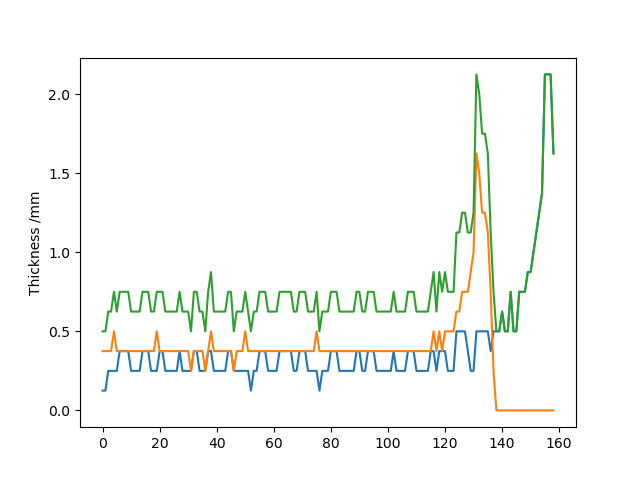

In [16]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.figure()
plt.ylabel("Thickness /mm")
plt.plot(lineThickness23, label = '23')
plt.plot(lineThickness45, label = '45')
plt.plot(lineThickness, label = 'Total')
plt.show()

In [17]:
#theta = 23
geolines=[]
ref0s =[]
ref90s = []
startPts =[]
startVecs =[]
t0 = time.time()
for i in range(len(seeds['pts'])):
    theta = seeds['thetas'][i]
    startPt = seeds['pts'][i]
    startPts.append(startPt)
    ref90 = seeds['ref90s'][i]
    ref90s.append(ref90)
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    ref0s.append(ref0)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    startVecs.append(startVec)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached on path 22.5
edge reached

In [18]:
theta = 45
geolines2=[]
t0 = time.time()

for i in range(len(seeds['pts'])):
    startPt = seeds['pts'][i]
    ref90 = seeds['ref90s'][i]
    startFace =seeds['faces'][i]
    ref0 = P3.Cross(ref90,tbm.faces[startFace].normal)
    startVec = rotAxisAngle(ref0,tbm.faces[startFace].normal,theta)
    forward = seeds['bFor'][i]
    geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True,tw = 6.35, forward = forward, maxPathLength = 1000)
    if len(geoline['pts']) < 3:
        geoline = createGeoLine(startPt, startFace, theta, ref90, calc_thick = True, tw = 6.35, forward = not forward, maxPathLength = 1000)
    geolines2.append(geoline)
print('Time taken:',time.time()-t0, 's')

edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on path 45
edge reached on 

In [19]:
CPT = 0.125
thicks = np.zeros(len(tbm.nodes))

for geoline in geolines:
    for n in geoline['nodes']:
        thicks[n.i] += CPT
        
for geoline in geolines2:
    for n in geoline['nodes']:
        thicks[n.i] += CPT

thicks

array([0.75 , 0.75 , 0.625, ..., 0.625, 0.625, 0.625])

In [20]:
ps.init()
geonodes = []
geonodes2 = []
for geoline in geolines:
    geonodes = geonodes + geoline['pts']
for geoline in geolines2:
    geonodes2 = geonodes2 + geoline['pts'] 

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_surf.add_scalar_quantity("thickness", thicks, defined_on='vertices',enabled = True,cmap='coolwarm')
ps_startline = ps.register_curve_network('startline', P3list2array(startPts), 'line')
#ps_geoline = ps.register_curve_network('geoline', P3list2array(geoline['pts']), 'line')
plotlines =[]
#for i in range(len(geolines)):
#    plotlines.append(P3list2array(geolines[i]['pts']))
ps.register_curve_network('geolines', P3list2array(geonodes), 'line')
ps.register_curve_network('geolines2', P3list2array(geonodes2), 'line')
ps_startPts = ps.register_point_cloud('startPts', P3list2array(startPts))
ps_SP = ps.register_point_cloud("seedpts", P3list2array(seeds['pts']))
#ps_SP1 = ps.register_point_cloud("Start1", P3list2array([start1]))
ps_startPts.add_vector_quantity("ref90", P3list2array(ref90s))
ps_startPts.add_vector_quantity("ref0", P3list2array(ref0s))
ps_startPts.add_vector_quantity("startVec", P3list2array(startVecs))
ps.show()

ps.clear_user_callback()

In [21]:
ps.init()
#for i in range(len(tbm.bars)):
#    pt1 = tbm.bars[i].GetNodeFore(True).p
#    pt2 = tbm.bars[i].GetNodeFore(False).p
#    nodes = np.array([(pt1.x,pt1.y,pt1.z),(pt2.x,pt2.y,pt2.z)])
#    ps_net = ps.register_curve_network('bar'+str(i), nodes, 'line',radius = 0.002, enabled=False)
ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_cloud = ps.register_point_cloud("vertices", V)
#ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
#ps_SP.add_vector_quantity("ref", np.array([ref90]))
#for i in range(len(geopaths)):
#    ps_geopath = ps.register_curve_network(str(i), P3list2array(geopaths[i]), 'line')
#    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))
ps_surf.add_vector_quantity("normals", n, defined_on='faces', color=(1, 0.5, 0.5))
ps.show()

AttributeError: 'TriangleNode' object has no attribute 'shape'

In [8]:
ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False, color = (10,250,10))
#ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
#ps_SP.add_vector_quantity("ref", np.array([ref90]))


#    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))        

ps.set_user_callback(increment_path)
#ps.set_user_callback(draw_paths)



ps.show()

ps.clear_user_callback()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 21.2.6
face 4608
face 578
face 3358


In [13]:
ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_SP = ps.register_point_cloud("Start", P3list2array([startPt]))
ps_SP.add_vector_quantity("ref", np.array([ref90]))
for i in range(len(geopaths)):
    ps_geopath = ps.register_curve_network(str(i), P3list2array(geopaths[i]), 'line')
    ps_geopath.add_scalar_quantity("curvature", np.array(curvs[i]), defined_on='edges', enabled=True,  cmap='coolwarm',vminmax=(-0.1, 0.1))
ps.show()

NameError: name 'startPt' is not defined